### Import necessory libraries

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
import os
import glob
from concurrent.futures import ThreadPoolExecutor
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)



### Load Images with Parallelization

In [ ]:

def load_image(file):
    try:
        img = cv2.imread(file)
        if img is not None:
            return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        return None
    except Exception as e:
        print(f"Error loading image {file}: {e}")
        return None

def load_and_visualize_data(data_dir='cell_images', dataset_size=10000):
    images, labels = [], []
    
    # Define paths
    parasitized_dir = os.path.join(data_dir, 'Parasitized')
    uninfected_dir = os.path.join(data_dir, 'Uninfected')
    
    # Get image files
    parasitized_files = glob.glob(os.path.join(parasitized_dir, '*.png'))
    uninfected_files = glob.glob(os.path.join(uninfected_dir, '*.png'))
    
    # Limit to dataset_size/2 per class and shuffle
    random.shuffle(parasitized_files)
    random.shuffle(uninfected_files)
    parasitized_files = parasitized_files[:dataset_size//2]
    uninfected_files = uninfected_files[:dataset_size//2]
    files = parasitized_files + uninfected_files
    labels = [1] * len(parasitized_files) + [0] * len(uninfected_files)
    
    # Parallelize image loading
    with ThreadPoolExecutor() as executor:
        images = list(executor.map(load_image, files))
    
    # Filter out None values (corrupted images)
    valid_pairs = [(img, lbl) for img, lbl in zip(images, labels) if img is not None]
    images = [pair[0] for pair in valid_pairs]
    labels = [pair[1] for pair in valid_pairs]
    
    # Visualize 10 samples
    plt.figure(figsize=(10, 5))
    for i in range(min(10, len(images))):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.title("Parasitized" if labels[i] else "Uninfected")
        plt.axis('off')
    plt.show()
    
    return images, np.array(labels)


### Batch Preprocessing

In [ ]:
def preprocess_images_in_batches(images, target_size=(64, 64), batch_size=32):
    batch_images = []
    for i, img in enumerate(images):
        try:
            img_resized = cv2.resize(img, target_size)
            img_normalized = img_resized / 255.0
            batch_images.append(img_normalized)
            if len(batch_images) == batch_size or i == len(images) - 1:
                yield np.array(batch_images)
                batch_images = []
        except Exception as e:
            print(f"Error processing image {i}: {e}")

### HOG Feature Extraction with Generator

In [ ]:
def extract_hog_features_generator(images):
    for img in images:
        try:
            gray_img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_RGB2GRAY)
            fd = hog(gray_img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            yield fd
        except Exception as e:
            print(f"Error extracting HOG for image: {e}")


### Process Data and Extract Features

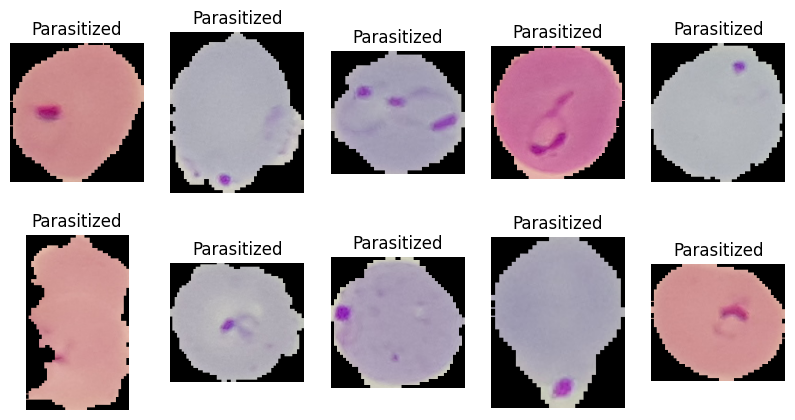

HOG Feature Shape: (10000, 1568)


In [ ]:
def process_and_extract_features(images, labels, batch_size=32):
    X_features, y_valid = [], []
    
    # Process images in batches
    for batch_images in preprocess_images_in_batches(images, batch_size=batch_size):
        # Extract HOG features for the batch
        batch_features = list(extract_hog_features_generator(batch_images))
        X_features.extend(batch_features)
        y_valid.extend(labels[len(X_features)-len(batch_features):len(X_features)])
    
    return np.array(X_features), np.array(y_valid)

# Load data
images, y = load_and_visualize_data(data_dir='cell_images', dataset_size=10000)

# Process and extract features
X_features, y = process_and_extract_features(images, y, batch_size=32)
print(f"HOG Feature Shape: {X_features.shape}")


### Dimensionality Reduction with PCA

In [ ]:
pca = PCA(n_components=100, random_state=42)
X_features_pca = pca.fit_transform(X_features)
print(f"PCA Feature Shape: {X_features_pca.shape}")
print(f"Explained Variance Ratio: {sum(pca.explained_variance_ratio_):.4f}")

#Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)

PCA Feature Shape: (10000, 100)
Explained Variance Ratio: 0.6347


### Train SVM with Hyperparameter Tuning

In [ ]:
# Subsample training data for tuning
subsample_size = 4000
if len(X_train) > subsample_size:
    idx = np.random.choice(len(X_train), subsample_size, replace=False)
    X_train_sub = X_train[idx]
    y_train_sub = y_train[idx]
else:
    X_train_sub, y_train_sub = X_train, y_train

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],  # Focus on RBF for speed
    'gamma': ['scale', 'auto']
}
svm = SVC(probability=False)  # Disable probability during tuning
random_search = RandomizedSearchCV(
    svm, param_grid, n_iter=6, cv=5, n_jobs=-1, verbose=1, random_state=42
)
random_search.fit(X_train_sub, y_train_sub)

# Best parameters
print(f"Best Parameters: {random_search.best_params_}")

# Train final model on full training data with best parameters
best_svm = SVC(probability=True, **random_search.best_params_)
best_svm.fit(X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}


SVC(C=10, probability=True)

### Evaluate 

In [ ]:

y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)
y_test_proba = best_svm.predict_proba(X_test)[:, 1]  # For ROC-AUC

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print("=== SVM Performance ===")
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=["Uninfected", "Parasitized"]))

=== SVM Performance ===
Training Accuracy: 1.00
Testing Accuracy: 0.84
F1-Score: 0.84
ROC-AUC: 0.93

Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.85      0.83      0.84      1000
 Parasitized       0.83      0.85      0.84      1000

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

